## Setup

In [1]:
# !nvidia-smi

In [2]:
# !pip install transformers
# !pip install sentencepiece
# !pip install jiwer
# !pip install datasets
# !pip install evaluate
# !pip install -U accelerate

# !pip install matplotlib
# !pip install protobuf==3.20.1
# !pip install tensorboard

## Imports

In [3]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import csv
import time


from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel, 
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)
from torch.utils.tensorboard import SummaryWriter
block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

In [4]:
bold = f"\033[1m"
reset = f"\033[0m"

In [5]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## Download and Extract the Dataset

In [7]:
# def download_and_unzip(url, save_path):
#     print(f"Downloading and extracting assets....", end="")

#     # Downloading zip file using urllib package.
#     urlretrieve(url, save_path)

#     try:
#         # Extracting zip file using the zipfile package.
#         with ZipFile(save_path) as z:
#             # Extract ZIP file contents in the same directory.
#             z.extractall(os.path.split(save_path)[0])

#         print("Done")

#     except Exception as e:
#         print("\nInvalid file.", e)

In [8]:
# URL = r"https://github.com/OSWINCHEONG/Number-Plate-Recognition/blob/main/Dataset_1.zip"
# asset_zip_path = os.path.join(os.getcwd(), "Dataset_1.zip")
# # Download if asset ZIP does not exist.
# if not os.path.exists(asset_zip_path):
#     download_and_unzip(URL, asset_zip_path)

## Training and Dataset Configurations

Configure this block of code only

In [9]:
# Parameters
batch_size = 8
epochs = 20
learning_rate = 0.001

# File path
data_root_base = r'C:\\Users\Oswin\Desktop\FYP\ANPR-1\Datasets\Dataset_all'
dataset_type = 'warped'
model_name = 'microsoft/trocr-small-printed'
   

In [10]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = batch_size
    EPOCHS:        int = epochs
    LEARNING_RATE: float = learning_rate

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:      str = os.path.join(data_root_base, dataset_type)

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = model_name

## Dataset

```
Dataset/dataset_type
├── train
├── test
├── train.txt
└── test.txt
```

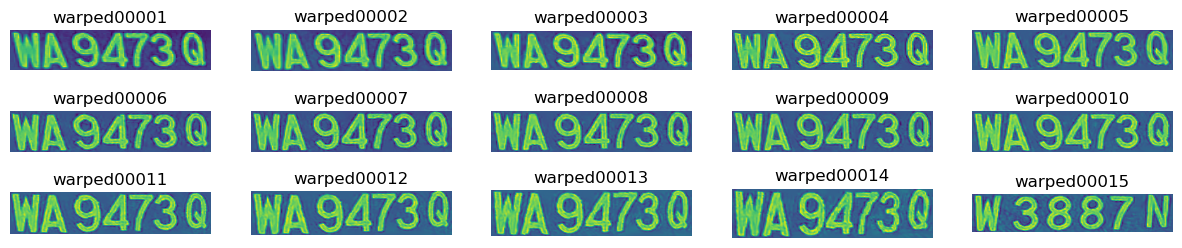

In [11]:
def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(f"{dataset_path}/train")
        image = plt.imread(f"{dataset_path}/train/{all_images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()

visualize(DatasetConfig.DATA_ROOT)

## Prepare Dataset

In [12]:
train_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'train.txt'), header=None
)
train_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)
valid_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'valid.txt'), header=None
)
valid_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)

In [13]:
train_df.head()

file_name    text
0  warped00101.jpg  A3831S
1  warped00102.jpg  A3831S
2  warped00103.jpg  A3831S
3  warped00104.jpg  A3831S
4  warped00138.jpg  A3942L

In [14]:
valid_df.head()

file_name     text
0  warped00633.jpg  WC4887V
1  warped00634.jpg  WC4887V
2  warped00635.jpg  WC4887V
3  warped00636.jpg  WC4887V
4  warped00637.jpg  WC4887V

In [15]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

In [16]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [17]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'train/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'valid/'),
    df=valid_df,
    processor=processor
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [18]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 878
Number of validation examples: 109


In [19]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


(-0.5, 118.5, 18.5, -0.5)

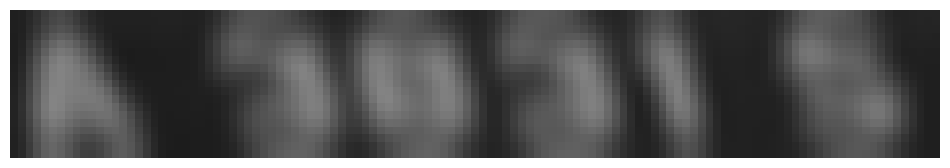

In [20]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image = train_transforms(image)
plt.imshow(image)
plt.axis('off')

In [21]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

A3831S


## Initialize the Model

In [22]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

## Model Configurations

In [23]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

We use the AdamW optimizer here with a weight decay of 0.0005.

In [24]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

## Evaluation Metric

In [25]:
cer_metric = evaluate.load('cer')

In [26]:
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

## Training and Validation Loops

In [27]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [28]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator,
)

c:\Users\Oswin\anaconda3\Lib\site-packages\transformers\models\trocr\processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
c:\Users\Oswin\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Train

In [29]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [30]:
res = trainer.train()

  0%|          | 0/2200 [00:00<?, ?it/s]

{'loss': 1.6056, 'grad_norm': 10.198637962341309, 'learning_rate': 4.75e-05, 'epoch': 1.0}


c:\Users\Oswin\anaconda3\Lib\site-packages\transformers\generation\utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 2.178649663925171, 'eval_cer': 0.20488466757123475, 'eval_runtime': 6.0266, 'eval_samples_per_second': 18.086, 'eval_steps_per_second': 2.323, 'epoch': 1.0}
{'loss': 0.4241, 'grad_norm': 19.775218963623047, 'learning_rate': 4.5e-05, 'epoch': 2.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.823476791381836, 'eval_cer': 0.19810040705563092, 'eval_runtime': 6.0923, 'eval_samples_per_second': 17.891, 'eval_steps_per_second': 2.298, 'epoch': 2.0}
{'loss': 0.2078, 'grad_norm': 8.301885604858398, 'learning_rate': 4.25e-05, 'epoch': 3.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.576711654663086, 'eval_cer': 0.07327001356852103, 'eval_runtime': 5.4434, 'eval_samples_per_second': 20.024, 'eval_steps_per_second': 2.572, 'epoch': 3.0}
{'loss': 0.0768, 'grad_norm': 20.224428176879883, 'learning_rate': 4e-05, 'epoch': 4.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 3.8296544551849365, 'eval_cer': 0.4626865671641791, 'eval_runtime': 6.1402, 'eval_samples_per_second': 17.752, 'eval_steps_per_second': 2.28, 'epoch': 4.0}
{'loss': 0.0647, 'grad_norm': 1.722163438796997, 'learning_rate': 3.7500000000000003e-05, 'epoch': 5.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 2.0063576698303223, 'eval_cer': 0.08005427408412483, 'eval_runtime': 5.3013, 'eval_samples_per_second': 20.561, 'eval_steps_per_second': 2.641, 'epoch': 5.0}
{'loss': 0.027, 'grad_norm': 1.2002034187316895, 'learning_rate': 3.5e-05, 'epoch': 6.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 2.249509572982788, 'eval_cer': 0.16010854816824965, 'eval_runtime': 5.4075, 'eval_samples_per_second': 20.157, 'eval_steps_per_second': 2.589, 'epoch': 6.0}
{'loss': 0.0264, 'grad_norm': 0.07341693341732025, 'learning_rate': 3.2500000000000004e-05, 'epoch': 7.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 2.1278579235076904, 'eval_cer': 0.13568521031207598, 'eval_runtime': 5.4115, 'eval_samples_per_second': 20.142, 'eval_steps_per_second': 2.587, 'epoch': 7.0}
{'loss': 0.0149, 'grad_norm': 0.09447382390499115, 'learning_rate': 3e-05, 'epoch': 8.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 2.1154627799987793, 'eval_cer': 0.18046132971506107, 'eval_runtime': 5.3928, 'eval_samples_per_second': 20.212, 'eval_steps_per_second': 2.596, 'epoch': 8.0}
{'loss': 0.0133, 'grad_norm': 0.0400468148291111, 'learning_rate': 2.7500000000000004e-05, 'epoch': 9.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.8600717782974243, 'eval_cer': 0.07869742198100407, 'eval_runtime': 5.4852, 'eval_samples_per_second': 19.872, 'eval_steps_per_second': 2.552, 'epoch': 9.0}
{'loss': 0.0119, 'grad_norm': 0.0037945390213280916, 'learning_rate': 2.5e-05, 'epoch': 10.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.8612898588180542, 'eval_cer': 0.06784260515603799, 'eval_runtime': 5.5675, 'eval_samples_per_second': 19.578, 'eval_steps_per_second': 2.515, 'epoch': 10.0}
{'loss': 0.008, 'grad_norm': 0.0025139017961919308, 'learning_rate': 2.25e-05, 'epoch': 11.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.810058832168579, 'eval_cer': 0.09905020352781546, 'eval_runtime': 5.6604, 'eval_samples_per_second': 19.257, 'eval_steps_per_second': 2.473, 'epoch': 11.0}
{'loss': 0.0107, 'grad_norm': 0.0679970234632492, 'learning_rate': 2e-05, 'epoch': 12.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.7893048524856567, 'eval_cer': 0.08683853459972862, 'eval_runtime': 4.8501, 'eval_samples_per_second': 22.474, 'eval_steps_per_second': 2.887, 'epoch': 12.0}
{'loss': 0.0047, 'grad_norm': 0.011955911293625832, 'learning_rate': 1.75e-05, 'epoch': 13.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.770644187927246, 'eval_cer': 0.09497964721845319, 'eval_runtime': 4.9505, 'eval_samples_per_second': 22.018, 'eval_steps_per_second': 2.828, 'epoch': 13.0}
{'loss': 0.01, 'grad_norm': 0.008183510974049568, 'learning_rate': 1.5e-05, 'epoch': 14.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.870234489440918, 'eval_cer': 0.06648575305291723, 'eval_runtime': 5.761, 'eval_samples_per_second': 18.92, 'eval_steps_per_second': 2.43, 'epoch': 14.0}
{'loss': 0.0025, 'grad_norm': 0.011025444604456425, 'learning_rate': 1.25e-05, 'epoch': 15.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.79746413230896, 'eval_cer': 0.08005427408412483, 'eval_runtime': 5.7358, 'eval_samples_per_second': 19.003, 'eval_steps_per_second': 2.441, 'epoch': 15.0}
{'loss': 0.0028, 'grad_norm': 0.0017350370762869716, 'learning_rate': 1e-05, 'epoch': 16.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.7286961078643799, 'eval_cer': 0.06919945725915876, 'eval_runtime': 5.2899, 'eval_samples_per_second': 20.605, 'eval_steps_per_second': 2.647, 'epoch': 16.0}
{'loss': 0.0042, 'grad_norm': 0.01165719609707594, 'learning_rate': 7.5e-06, 'epoch': 17.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.703952670097351, 'eval_cer': 0.06377204884667571, 'eval_runtime': 5.2371, 'eval_samples_per_second': 20.813, 'eval_steps_per_second': 2.673, 'epoch': 17.0}
{'loss': 0.0018, 'grad_norm': 0.005610231310129166, 'learning_rate': 5e-06, 'epoch': 18.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.708739995956421, 'eval_cer': 0.06377204884667571, 'eval_runtime': 5.2867, 'eval_samples_per_second': 20.618, 'eval_steps_per_second': 2.648, 'epoch': 18.0}
{'loss': 0.0009, 'grad_norm': 0.0032480908557772636, 'learning_rate': 2.5e-06, 'epoch': 19.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.7204577922821045, 'eval_cer': 0.05970149253731343, 'eval_runtime': 5.5596, 'eval_samples_per_second': 19.606, 'eval_steps_per_second': 2.518, 'epoch': 19.0}
{'loss': 0.0008, 'grad_norm': 0.01820116676390171, 'learning_rate': 0.0, 'epoch': 20.0}


  0%|          | 0/14 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


{'eval_loss': 1.703446388244629, 'eval_cer': 0.06377204884667571, 'eval_runtime': 5.226, 'eval_samples_per_second': 20.857, 'eval_steps_per_second': 2.679, 'epoch': 20.0}
{'train_runtime': 993.9544, 'train_samples_per_second': 17.667, 'train_steps_per_second': 2.213, 'train_loss': 0.12594853962348265, 'epoch': 20.0}


## Extract Training and Validation loss

In [31]:
# Initialize variables to store train loss and eval loss
train_loss_list = []
eval_loss_list = []

# Iterate over the log history
for log_entry in trainer.state.log_history:
    # Check if the log entry contains train loss
    if 'loss' in log_entry:
        train_loss_list.append(log_entry['loss'])
    # Check if the log entry contains eval loss
    if 'eval_loss' in log_entry:
        eval_loss_list.append(log_entry['eval_loss'])

# Print train loss and eval loss
print("Train Loss:", train_loss_list)
print("Eval Loss:", eval_loss_list)


Train Loss: [1.6056, 0.4241, 0.2078, 0.0768, 0.0647, 0.027, 0.0264, 0.0149, 0.0133, 0.0119, 0.008, 0.0107, 0.0047, 0.01, 0.0025, 0.0028, 0.0042, 0.0018, 0.0009, 0.0008]
Eval Loss: [2.178649663925171, 1.823476791381836, 1.576711654663086, 3.8296544551849365, 2.0063576698303223, 2.249509572982788, 2.1278579235076904, 2.1154627799987793, 1.8600717782974243, 1.8612898588180542, 1.810058832168579, 1.7893048524856567, 1.770644187927246, 1.870234489440918, 1.79746413230896, 1.7286961078643799, 1.703952670097351, 1.708739995956421, 1.7204577922821045, 1.703446388244629]


## Plot Training and validation losses

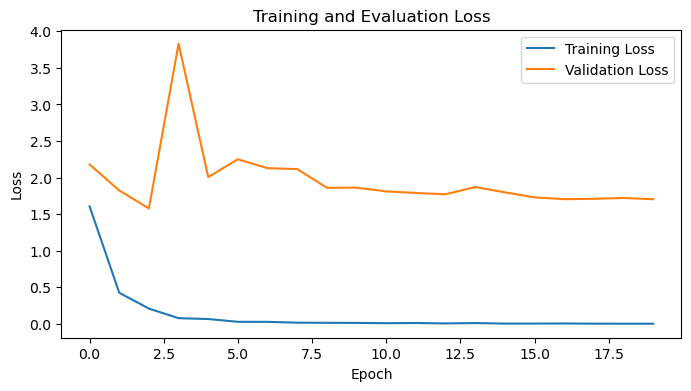

In [32]:
# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_loss_list, label='Training Loss')

# Plot evaluation loss
plt.plot(eval_loss_list, label='Validation Loss')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()

# Show plot
plt.show()

## Inference

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [34]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step)).to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [35]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [36]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [37]:
def eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test', '*'),
    ground_truth_path=os.path.join(DatasetConfig.DATA_ROOT, 'test.txt'),
    num_samples=len(valid_dataset)
):
    total_correct = 0
    total_samples = 0
    total_latency = 0
    generated_texts = []  # List to store generated texts
    ground_truth_labels = [] # List to store ground truth labels
    
    # Read ground truth from file
    with open(ground_truth_path, 'r') as f:
        ground_truth_data = f.readlines()
    
    # Create a dictionary to store ground truth for quick lookup
    ground_truth_dict = {}
    for line in ground_truth_data:
        filename, ground_truth = line.strip().split('\t')
        ground_truth_dict[filename] = ground_truth
    
    # Get image paths
    image_paths = glob.glob(data_path)  # Assuming images are in JPEG format
    
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        
        # Read and process image
        image = read_and_show(image_path)
        
        # Measure latency
        start_time = time.time()
        text = ocr(image, processor, trained_model)
        end_time = time.time()
        latency = end_time - start_time
        total_latency += latency
        
        # Store generated text
        generated_texts.append(text)
        
        # Get ground truth from filename
        filename = os.path.basename(image_path)
        ground_truth = ground_truth_dict.get(filename, None)
        
        if ground_truth is not None:
            # Compare recognized text with ground truth for accuracy measurement
            if text == ground_truth:
                total_correct += 1
            total_samples += 1

            # Store ground truth label
            ground_truth_labels.append(ground_truth)
        
        # Display image and recognized text
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()
    
    # Calculate accuracy
    accuracy = (total_correct / total_samples) * 100 if total_samples > 0 else 0
    
    # Calculate average latency
    avg_latency = total_latency / num_samples
    
    # Print accuracy and latency
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Average latency: {avg_latency:.2f} seconds")
    
    return accuracy, avg_latency, generated_texts, ground_truth_labels


eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test', '*'),
    num_samples=100
)

  0%|          | 0/111 [00:00<?, ?it/s]

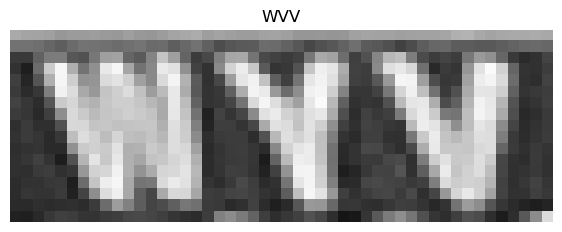

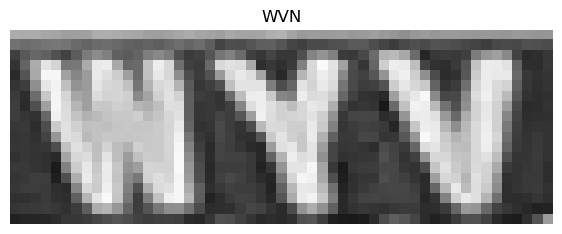

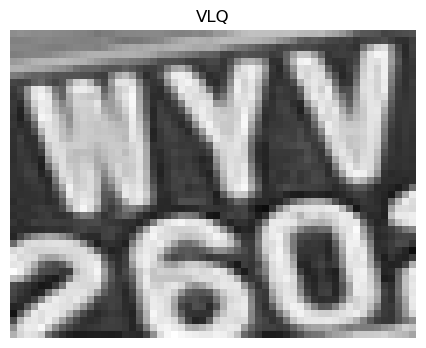

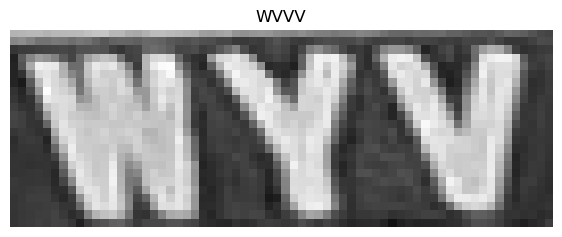

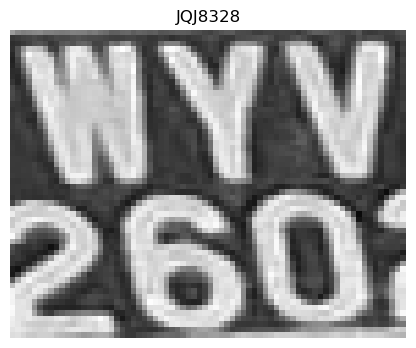

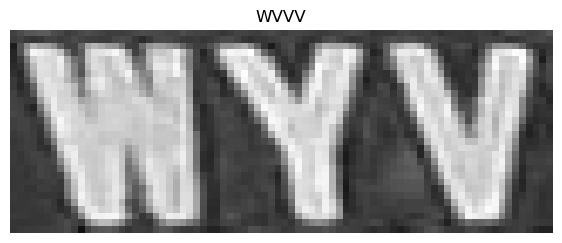

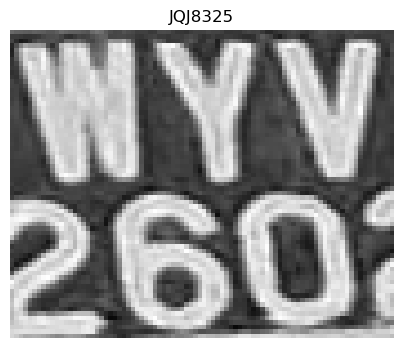

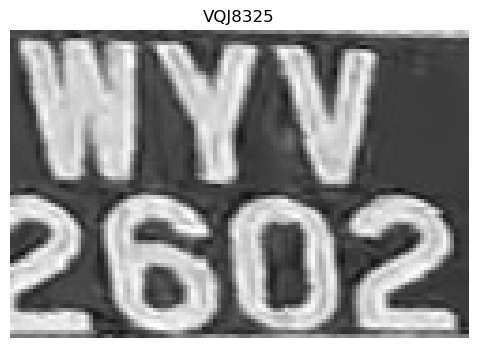

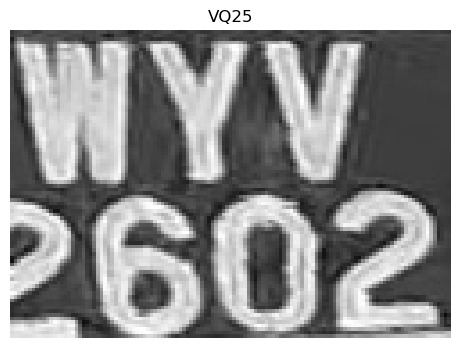

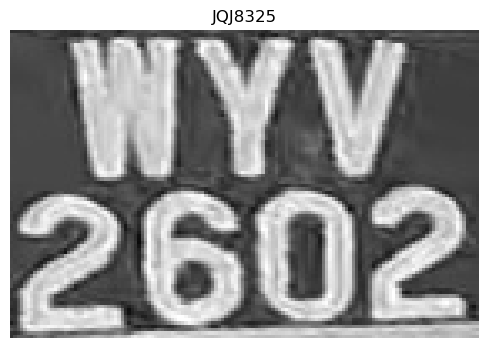

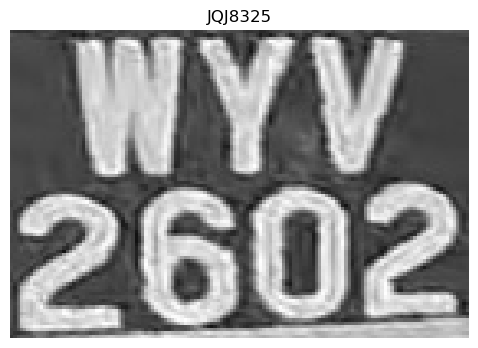

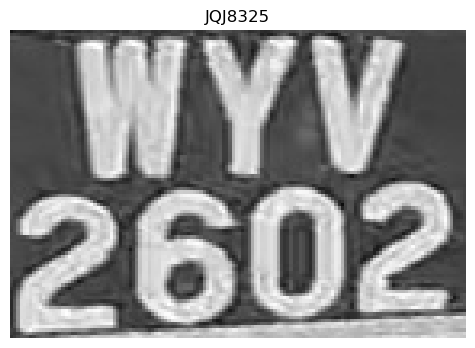

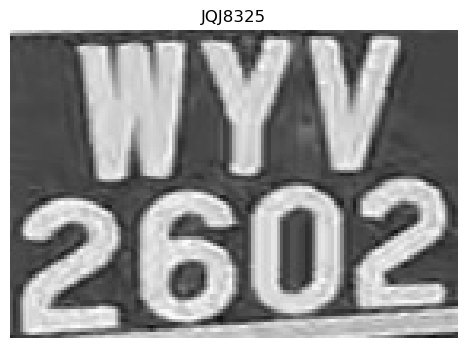

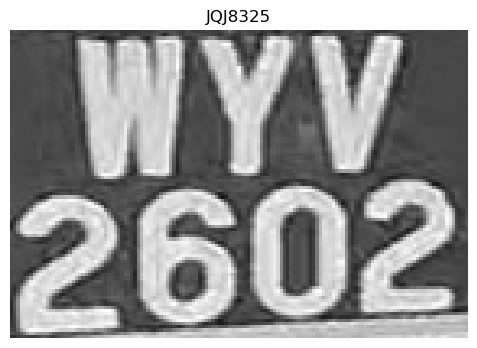

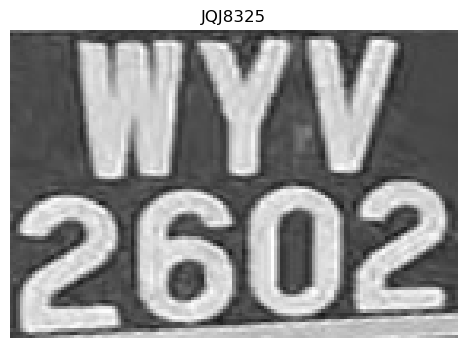

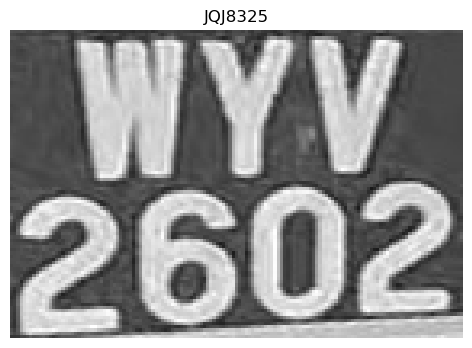

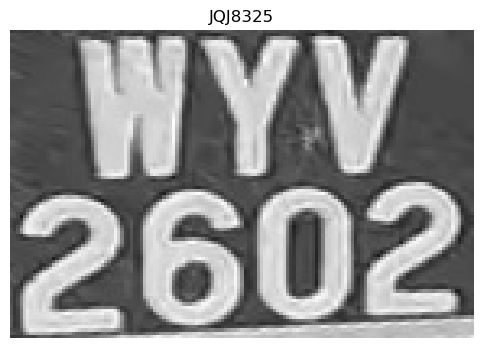

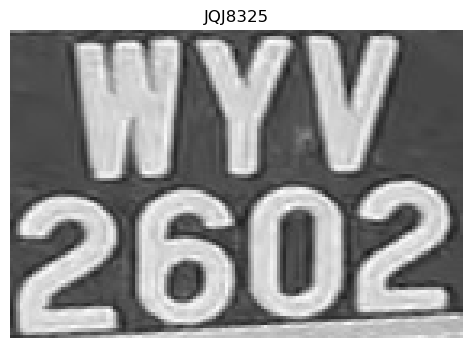

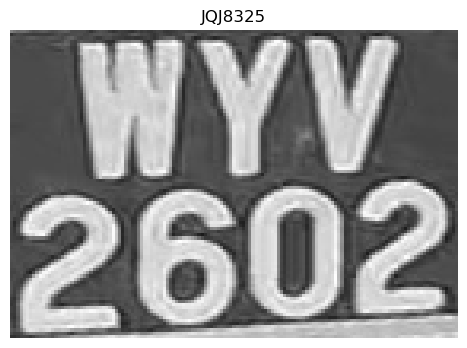

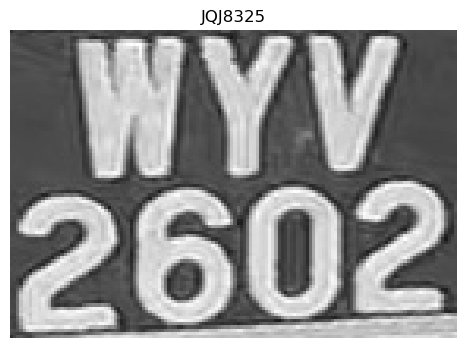

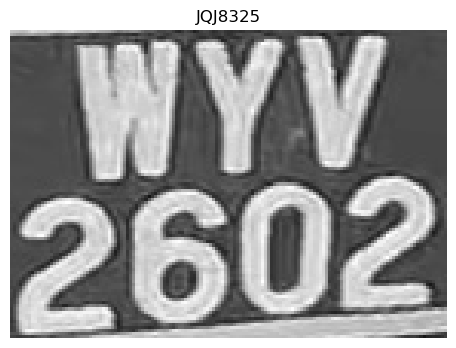

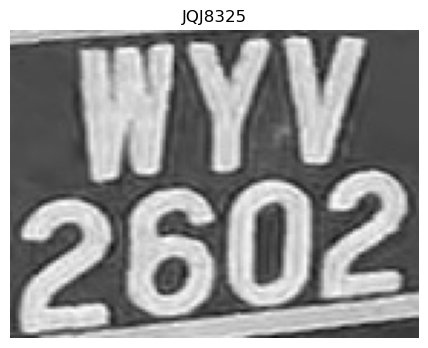

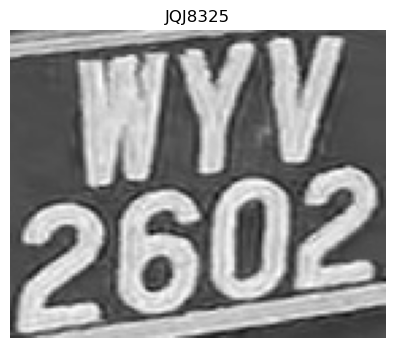

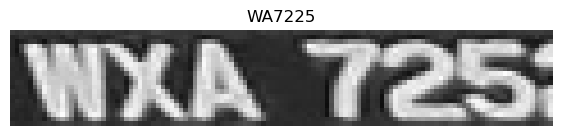

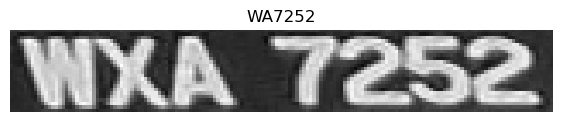

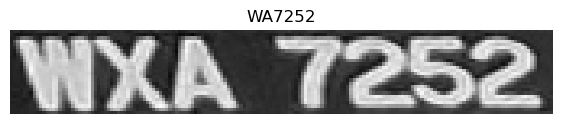

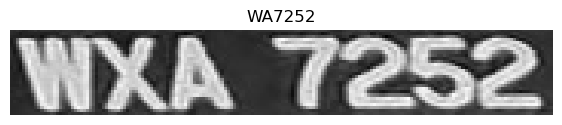

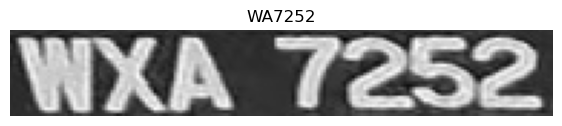

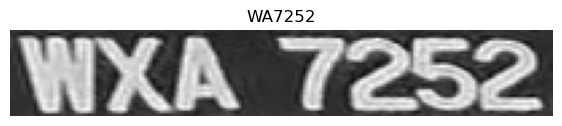

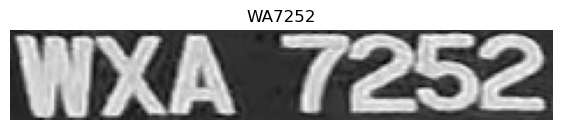

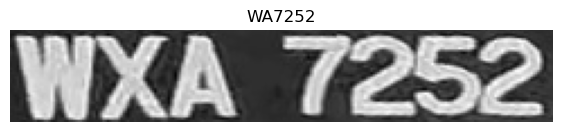

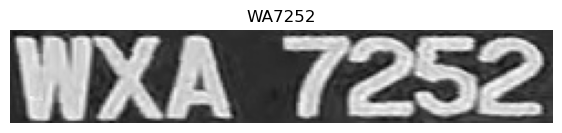

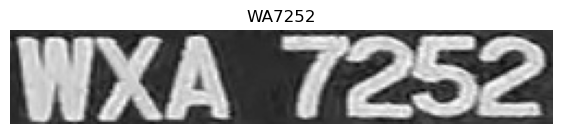

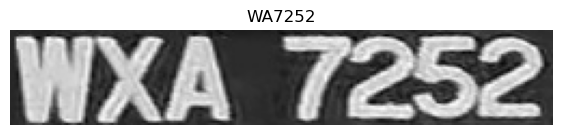

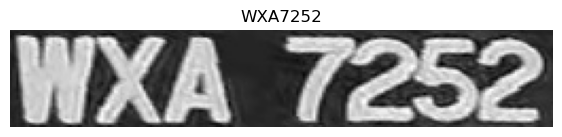

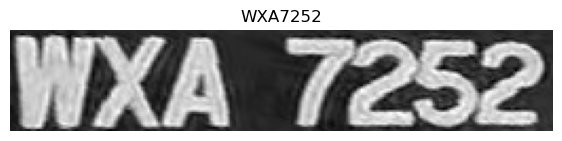

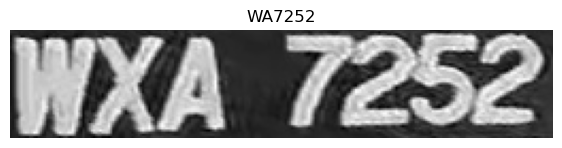

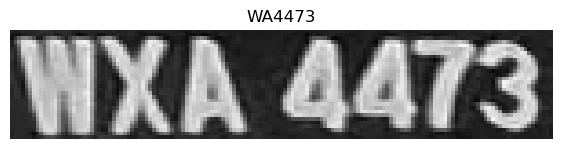

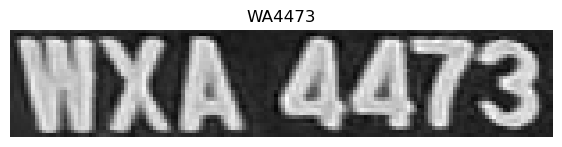

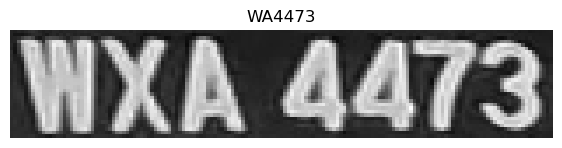

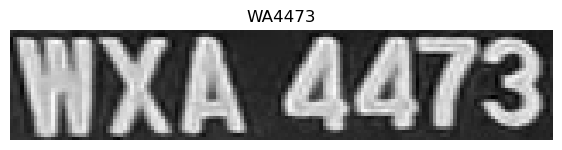

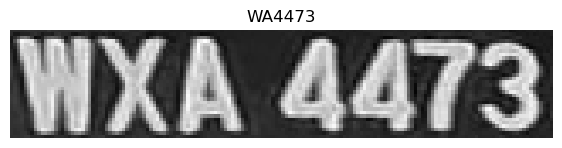

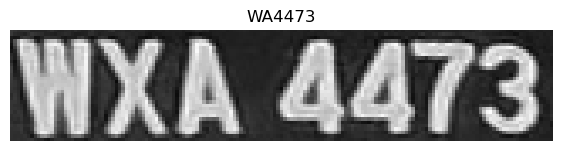

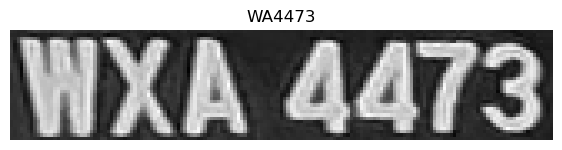

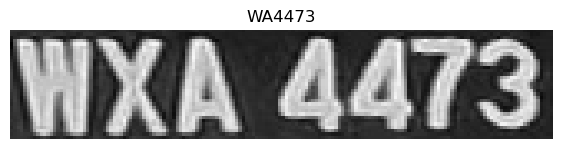

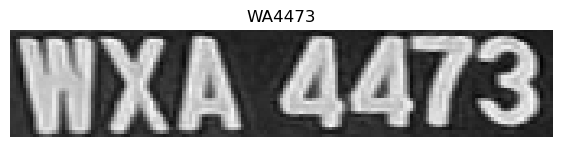

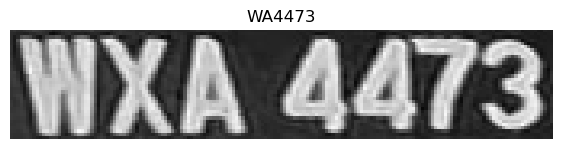

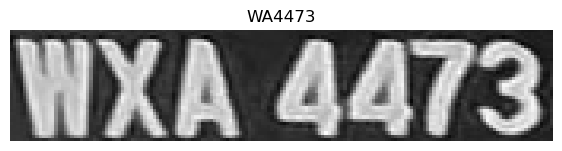

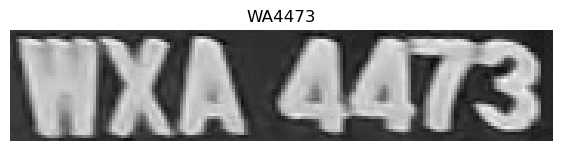

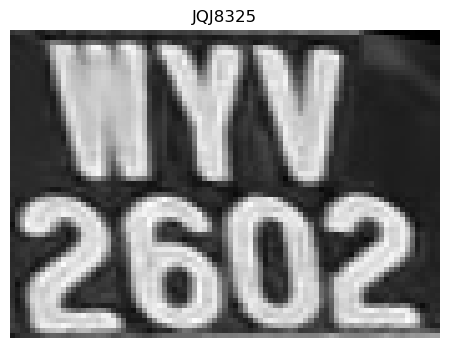

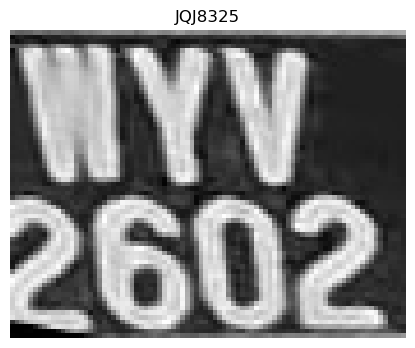

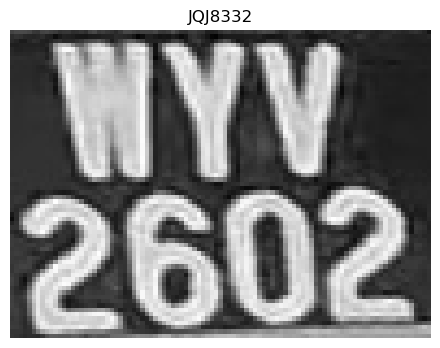

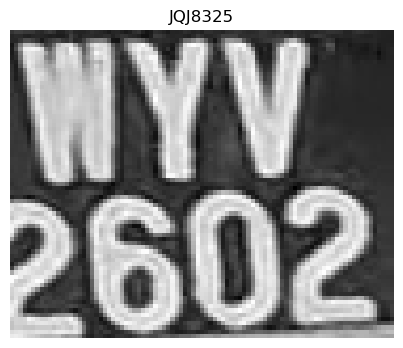

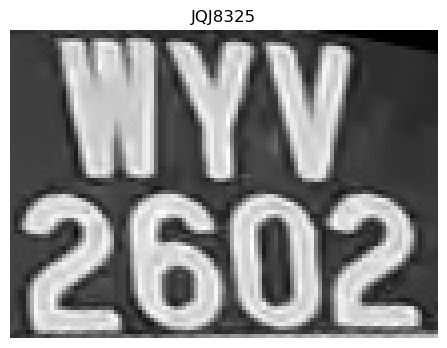

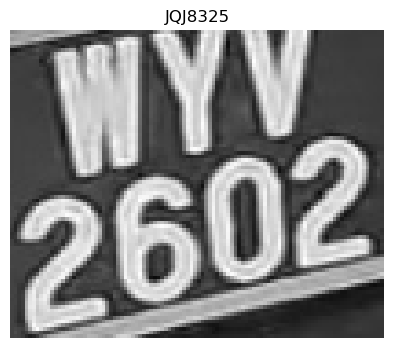

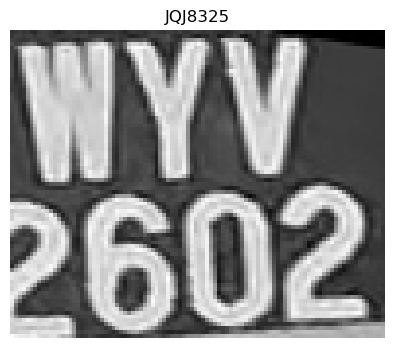

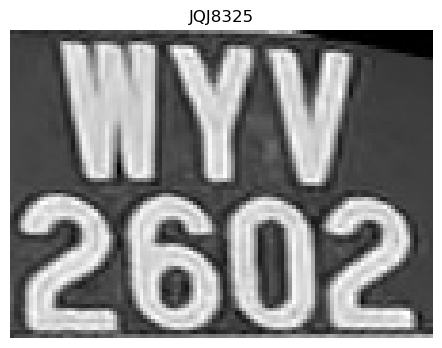

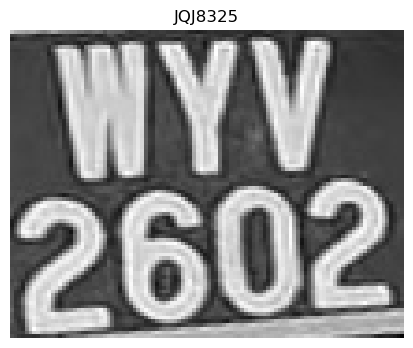

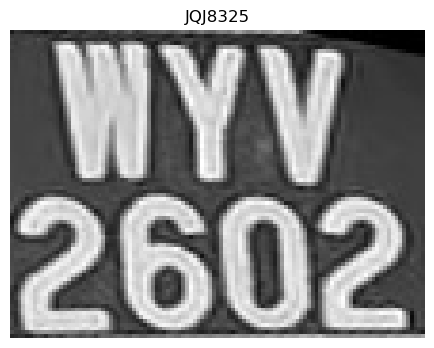

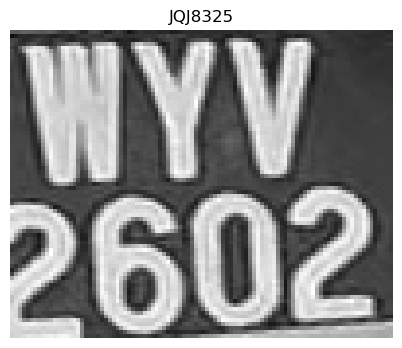

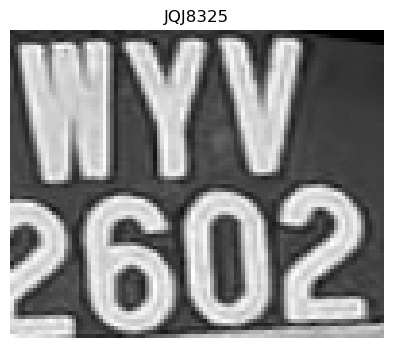

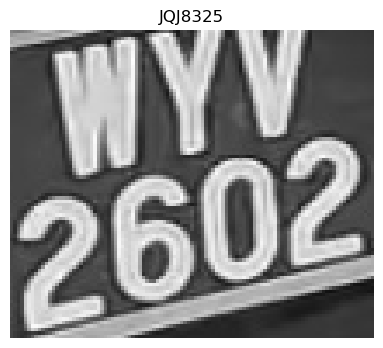

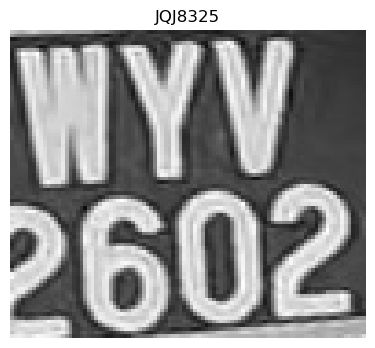

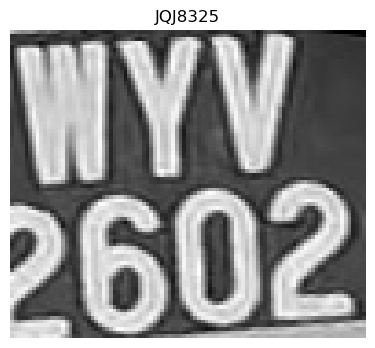

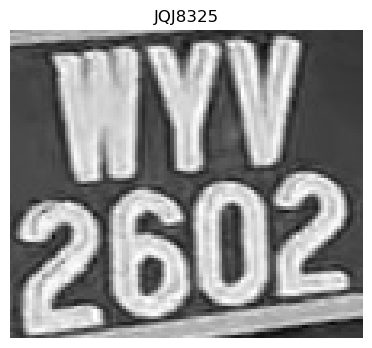

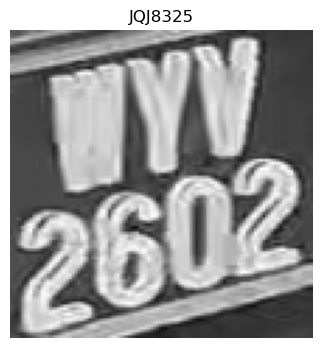

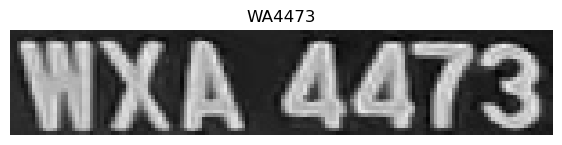

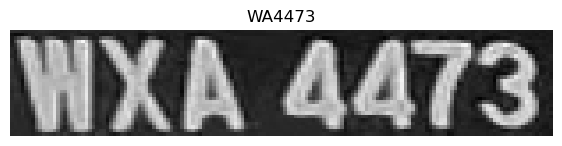

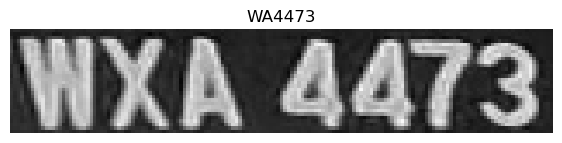

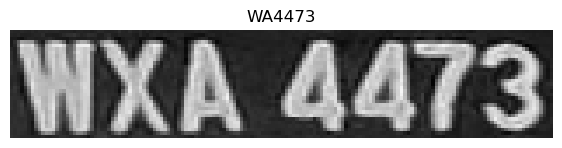

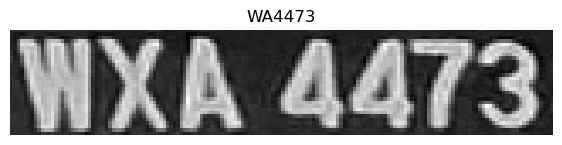

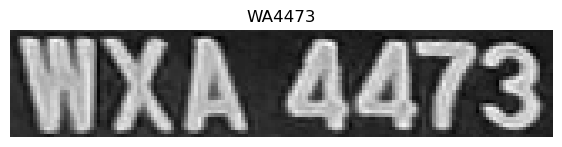

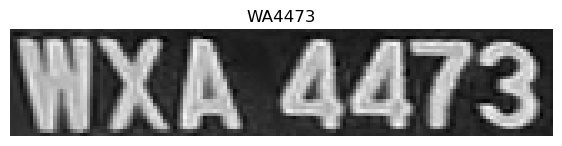

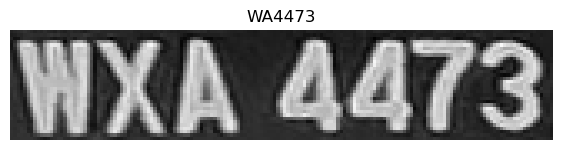

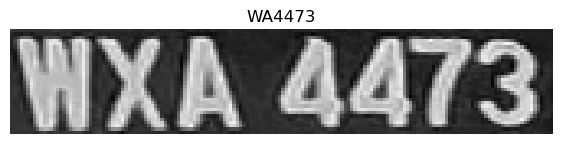

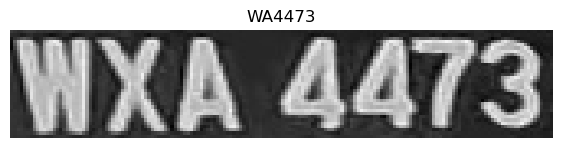

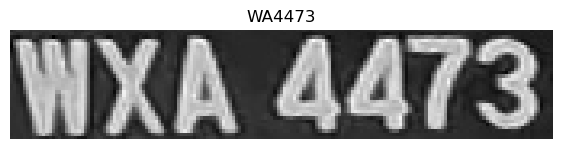

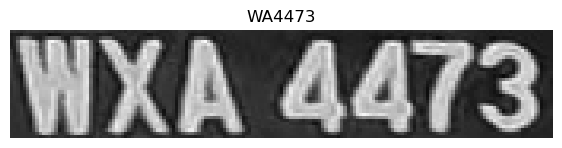

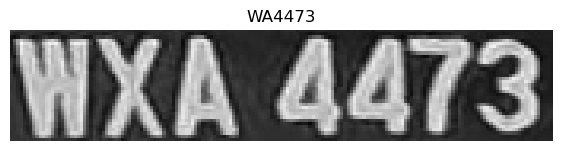

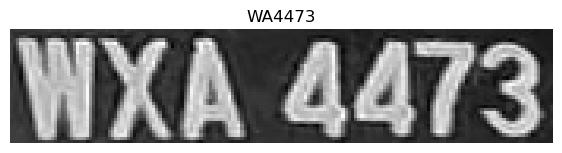

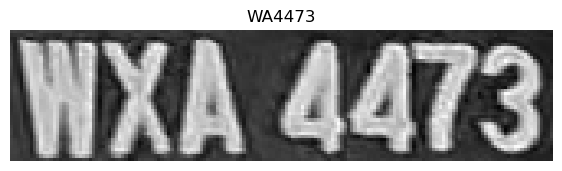

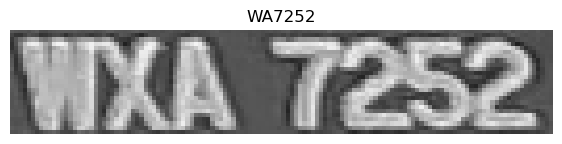

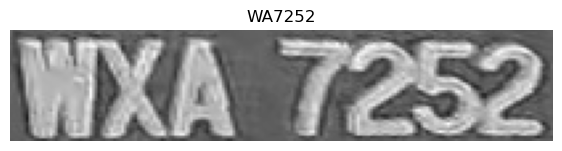

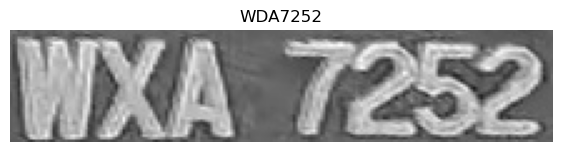

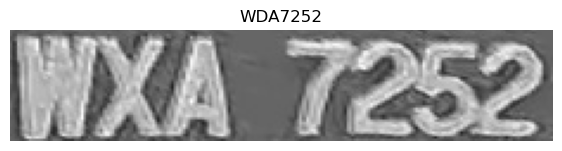

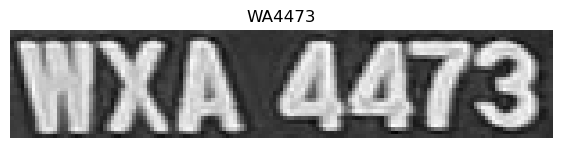

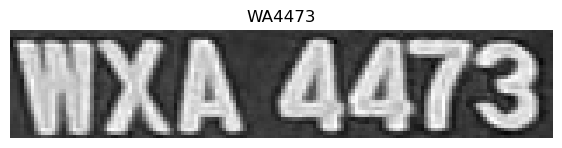

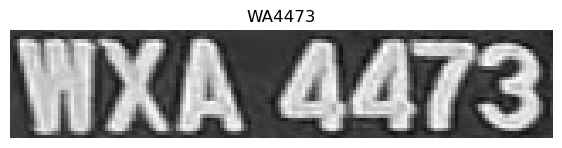

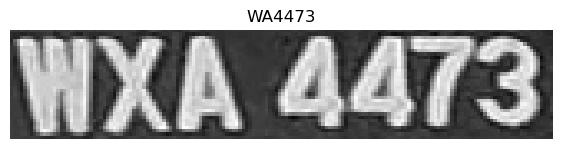

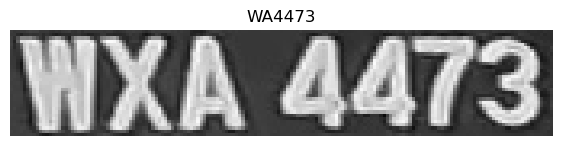

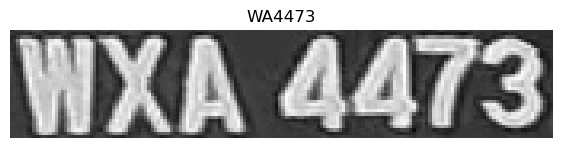

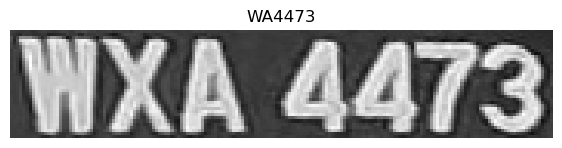

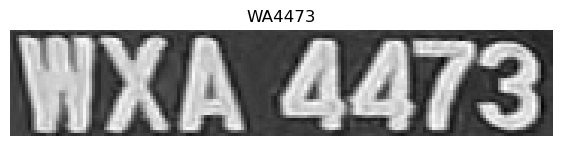

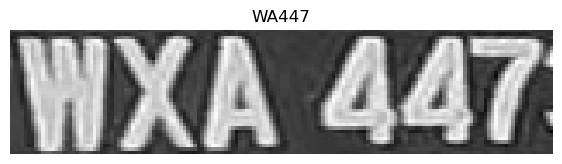

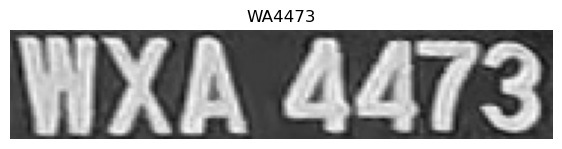

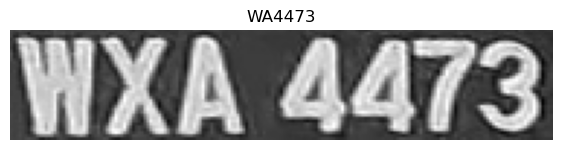

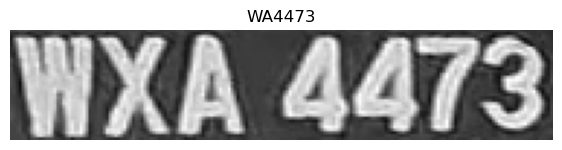

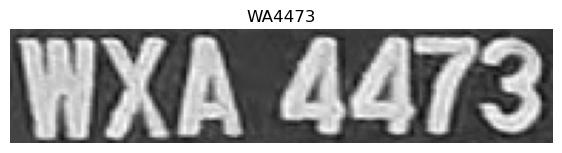

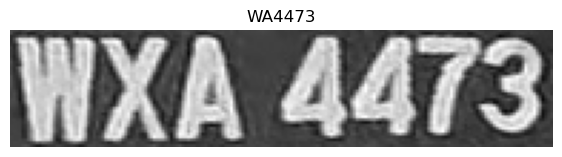

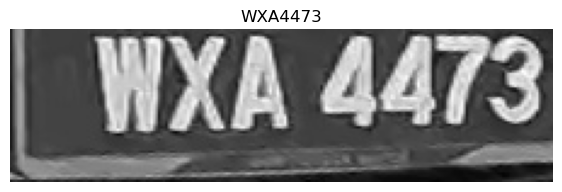

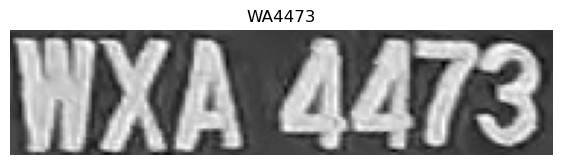

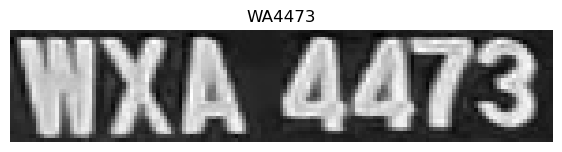

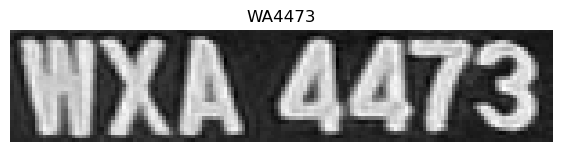

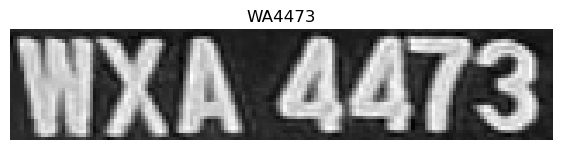

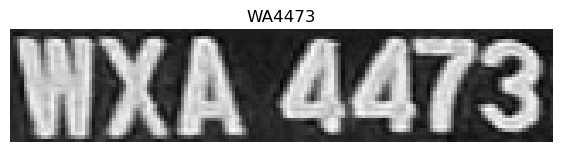

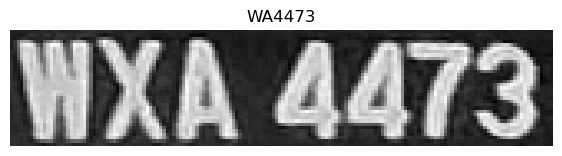

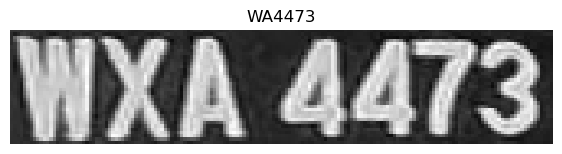

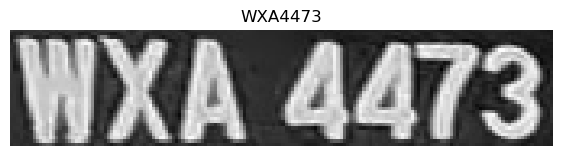

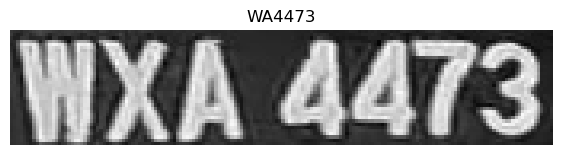

Accuracy: 3.67%
Average latency: 0.07 seconds


In [38]:
accuracy, avg_latency, predicted_labels, ground_truth_labels = eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test', '*'),
    ground_truth_path=os.path.join(DatasetConfig.DATA_ROOT, 'test.txt'),
    num_samples=len(valid_dataset)
)

In [39]:
results = {
    "accuracy": accuracy,
    "latency": avg_latency
}

## Character Error Analaysis

In [42]:
import string
from collections import defaultdict

def character_error_analysis(ground_truth_labels, predicted_labels):
    """
    Analyze character errors between ground truth and predicted labels.
    """
    # Define a set of all letters and numbers
    all_characters = set(string.ascii_letters + string.digits)
    
    # Initialize dictionaries to count errors per character
    total_characters = defaultdict(int)
    error_counts = defaultdict(int)
    
    # Iterate over each ground truth and predicted label pair
    for ground_truth, predicted in zip(ground_truth_labels, predicted_labels):
        # Iterate over each character in the ground truth label
        for gt_char, pred_char in zip(ground_truth, predicted):
            if gt_char in all_characters:  # Check if the character is a letter or number
                total_characters[gt_char] += 1
                if gt_char != pred_char:
                    error_counts[gt_char] += 1
    
    # Calculate error rates per character
    error_rates = {char: error_counts[char] / total_characters[char] for char in total_characters}
    
    return error_rates

In [43]:
error_rates = character_error_analysis(ground_truth_labels, predicted_labels)

# Print error rates for each character
for char, error_rate in error_rates.items():
    print(f"Character '{char}': Error Rate = {error_rate:.2f}")

Character 'W': Error Rate = 0.33
Character 'Y': Error Rate = 1.00
Character 'V': Error Rate = 0.93
Character '2': Error Rate = 0.89
Character '6': Error Rate = 1.00
Character '0': Error Rate = 1.00
Character 'X': Error Rate = 0.94
Character 'A': Error Rate = 0.91
Character '7': Error Rate = 0.91
Character '5': Error Rate = 0.72
Character '4': Error Rate = 0.48
Character '3': Error Rate = 0.00


## Save results to CSV

In [40]:
# Save results to a CSV file
# Construct the output CSV filename
output_csv = f"{ModelConfig.MODEL_NAME.split('/')[-1]}_{dataset_type}.csv"

# Specify the path to the directory where you want to save the CSV file
output_dir = DatasetConfig.DATA_ROOT

# Join the directory path and the filename to create the full file path
output_path = os.path.join(output_dir, output_csv)
with open(output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Title
    writer.writerow([output_csv])
    writer.writerow([])  # Empty row as a separator
    
    # Write parameters section
    writer.writerow(["Parameters"])
    writer.writerow(["Parameter", "Value"])
    writer.writerow(["Model", ModelConfig.MODEL_NAME])
    writer.writerow(["Type of Dataset", dataset_type])
    writer.writerow(["Training Size", len(train_dataset)])
    writer.writerow(["Validation Size", len(valid_dataset)])
    writer.writerow(["Test Size", len(valid_dataset)])
    writer.writerow(["Batch Size", TrainingConfig.BATCH_SIZE])
    writer.writerow(["Epochs", TrainingConfig.EPOCHS])
    writer.writerow(["Learning Rate", TrainingConfig.LEARNING_RATE])
    writer.writerow([])  # Empty row as a separator
    
    # Write metrics section
    writer.writerow(["Metrics"])
    writer.writerow(["Metric", "Value"])
    writer.writerow(["Accuracy", f"{accuracy:.2f}%"])
    writer.writerow(["Average Latency", f"{avg_latency*1000} ms"])

In [41]:
# # Generate example data for training and validation losses
# epochs = list(range(1, 11))
# train_loss = [0.5, 0.4, 0.3, 0.25, 0.2, 0.18, 0.15, 0.1, 0.08, 0.05]  # Example training loss (decreasing)
# valid_loss = [0.5, 0.4, 0.35, 0.4, 0.45, 0.6, 0.8, 1.0, 1.2, 1.5]  # Example validation loss (increasing)

# # Plot training and validation losses
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, valid_loss, label='Validation Loss')

# # Add labels and legend
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# # Show plot
# plt.show()
